##MLB Home Run Rates

### *Goals*:
- Estimate the Home Run Rate (*HR / AB*) for each player during the 2025 MLB season using a Bayesian Hierarchical Model
- Provide posterior means + 95% confidence intervals for the top 20 players.
- Produce a Posterior Predictive Check (PPC) figure.
- Reflection on shrinkage of player rates in the dataset.

In [15]:
# Install Some Dependancies
!pip install pybaseball --quiet

In [16]:
from pybaseball import batting_stats_bref

In [17]:
!git clone https://github.com/JoshD28/mlb-hr-rates.git
%cd mlb-hr-rates
!ls
!ls data


Cloning into 'mlb-hr-rates'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 32.65 KiB | 566.00 KiB/s, done.
/content/mlb-hr-rates/mlb-hr-rates/mlb-hr-rates
data  README.md
batting_stats_2025.csv


**Goal 1: Estimate the Home Run Rate (HR / AB) for each player during the 2025 MLB season using a Bayesian Hierarchical Model**

In [18]:
# Step 1: Load data

import pandas as pd
df = pd.read_csv("data/batting_stats_2025.csv")


In [19]:
# Step 2: Imports and plotting preferences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

sns.set(style="whitegrid", context="talk")
SEED = 42
np.random.seed(SEED)


In [20]:
# Step 3: Clean data and compute HR/AB rates

# Expect columns "Name", "HR", "AB". If your player column is different, update player_col.

player_col = "Name"

df = df.dropna(subset=["HR", "AB"]).copy()
df = df[df["AB"] > 0].copy()
df["HR"] = df["HR"].astype(int)
df["AB"] = df["AB"].astype(int)
df["HR/AB"] = df["HR"] / df["AB"]

if player_col not in df.columns:
    raise ValueError(f"Player column '{player_col}' not found. CSV columns: {list(df.columns)}")

print(df[[player_col, "HR", "AB", "HR/AB"]].head())


                      Name  HR   AB     HR/AB
0                CJ Abrams  19  580  0.032759
1             Wilyer Abreu  22  378  0.058201
2            Maximo Acosta   3   54  0.055556
3   Luisangel Acu\xc3\xb1a   0  175  0.000000
4  Ronald Acu\xc3\xb1a Jr.  21  338  0.062130


In [21]:
# Step 4: Compute independent Beta posterior (non-hierarchical) for comparison

alpha_prior = 1.0
beta_prior = 20.0
n_samps = 4000

df["alpha_post"] = df["HR"] + alpha_prior
df["beta_post"] = df["AB"] - df["HR"] + beta_prior

# Draw samples per player (list comprehension then array)
beta_samples = np.array([np.random.beta(a, b, size=n_samps) for a, b in zip(df["alpha_post"], df["beta_post"])])
# beta_samples shape = (n_players, n_samps)
df["beta_post_mean"] = beta_samples.mean(axis=1)
df["beta_post_lower"] = np.percentile(beta_samples, 2.5, axis=1)
df["beta_post_upper"] = np.percentile(beta_samples, 97.5, axis=1)


In [22]:
# Step 5: Hierarchical logit-normal Binomial model

overall_rate = df["HR/AB"].mean()
eps = 1e-6
overall_rate_clipped = np.clip(overall_rate, eps, 1 - eps)
logit_center = np.log(overall_rate_clipped / (1 - overall_rate_clipped))

N = len(df)
HR = df["HR"].values
AB = df["AB"].values

with pm.Model() as hierarchical_model:
    mu = pm.Normal("mu", mu=logit_center, sigma=2.0)
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # non-centered parameterization
    z = pm.Normal("z", 0.0, 1.0, shape=N)
    logit_theta = mu + sigma * z
    theta = pm.Deterministic("theta", pm.math.sigmoid(logit_theta))

    hr_obs = pm.Binomial("hr_obs", n=AB, p=theta, observed=HR)

    idata = pm.sample(draws=2000, tune=1000, target_accept=0.95,
                      random_seed=SEED, return_inferencedata=True)


Output()

**Goal 2: Provide posterior means + 95% confidence intervals for the top 20 players.**

In [23]:
import arviz as az

# Step 1: Extract posterior theta samples and compute posterior mean + 95% HDI per player

posterior_theta = idata.posterior["theta"]  # dims: (chain, draw, theta_dim_0)

# Calculate mean for each player across all samples
post_means = posterior_theta.mean(dim=["chain", "draw"]).values

# az.hdi returns an xarray DataArray. We will extract the lower and upper bounds from it.
hdi_result_da = az.hdi(posterior_theta, hdi_prob=0.95)

# The shape of hdi_result_da should now be (num_players, 2) where the last dim is 'hdi'.
# We extract the 'lower' (index 0) and 'upper' (index 1) values.
num_players = posterior_theta.shape[2] # Get number of players from the last dimension
total_samples = posterior_theta.shape[0] * posterior_theta.shape[1] # For print statement
print(f"Posterior samples for theta: total_samples={total_samples}, num_players={num_players}")

df = df.reset_index(drop=True)
df["hier_post_mean"] = post_means
df["hier_post_lower"] = hdi_result_da['theta'].isel(hdi=0).values
df["hier_post_upper"] = hdi_result_da['theta'].isel(hdi=1).values

# Top 20 players by hierarchical posterior mean
top20 = df.sort_values("hier_post_mean", ascending=False).head(20).copy()
display_cols = [player_col, "HR", "AB", "HR/AB", "hier_post_mean", "hier_post_lower", "hier_post_upper"]
print("\nTop 20 (hierarchical posterior mean):")
print(top20[display_cols].to_string(index=False))

Posterior samples for theta: total_samples=4000, num_players=674

Top 20 (hierarchical posterior mean):
                 Name  HR  AB    HR/AB  hier_post_mean  hier_post_lower  hier_post_upper
          Cal Raleigh  64 639 0.100156        0.091334         0.070574         0.112079
          Aaron Judge  54 567 0.095238        0.085925         0.064348         0.107760
       Kyle Schwarber  58 620 0.093548        0.085110         0.065167         0.106256
        Shohei Ohtani  60 652 0.092025        0.084235         0.064917         0.105858
Eugenio Su\xc3\xa1rez  52 631 0.082409        0.075174         0.056296         0.094693
           Nick Kurtz  36 420 0.085714        0.074570         0.052973         0.098913
    Giancarlo Stanton  24 275 0.087273        0.071570         0.045484         0.100092
      Junior Caminero  45 602 0.074751        0.067917         0.049649         0.086977
            Juan Soto  43 577 0.074523        0.067142         0.049447         0.086045
    Co

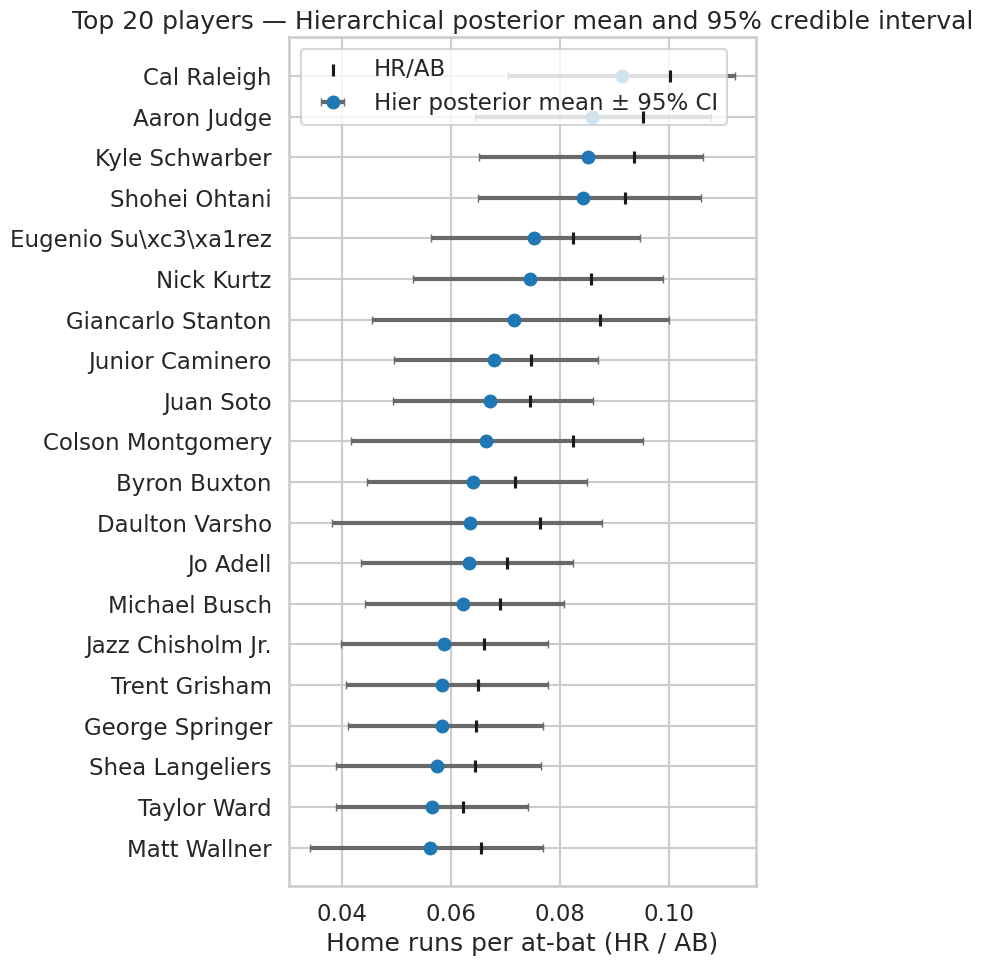

In [24]:
# Step 2: Forest plot (top 20) showing posterior means and 95% CI

order = top20.sort_values("hier_post_mean", ascending=True)  # for horizontal plotting
y_pos = np.arange(len(order))

plt.figure(figsize=(8, 10))
plt.errorbar(order["hier_post_mean"], y_pos,
             xerr=[order["hier_post_mean"] - order["hier_post_lower"],
                   order["hier_post_upper"] - order["hier_post_mean"]],
             fmt='o', color='tab:blue', ecolor='dimgray', elinewidth=3, capsize=3, label='Hier posterior mean ± 95% CI')
plt.scatter(order["HR/AB"], y_pos, marker='|', color='k', label='HR/AB', zorder=10)
plt.yticks(y_pos, order[player_col])
plt.xlabel("Home runs per at-bat (HR / AB)")
plt.title("Top 20 players — Hierarchical posterior mean and 95% credible interval")
plt.legend()
plt.tight_layout()
plt.show()


**Goal 3: Produce a Posterior Predictive Check (PPC) figure.**

Output()

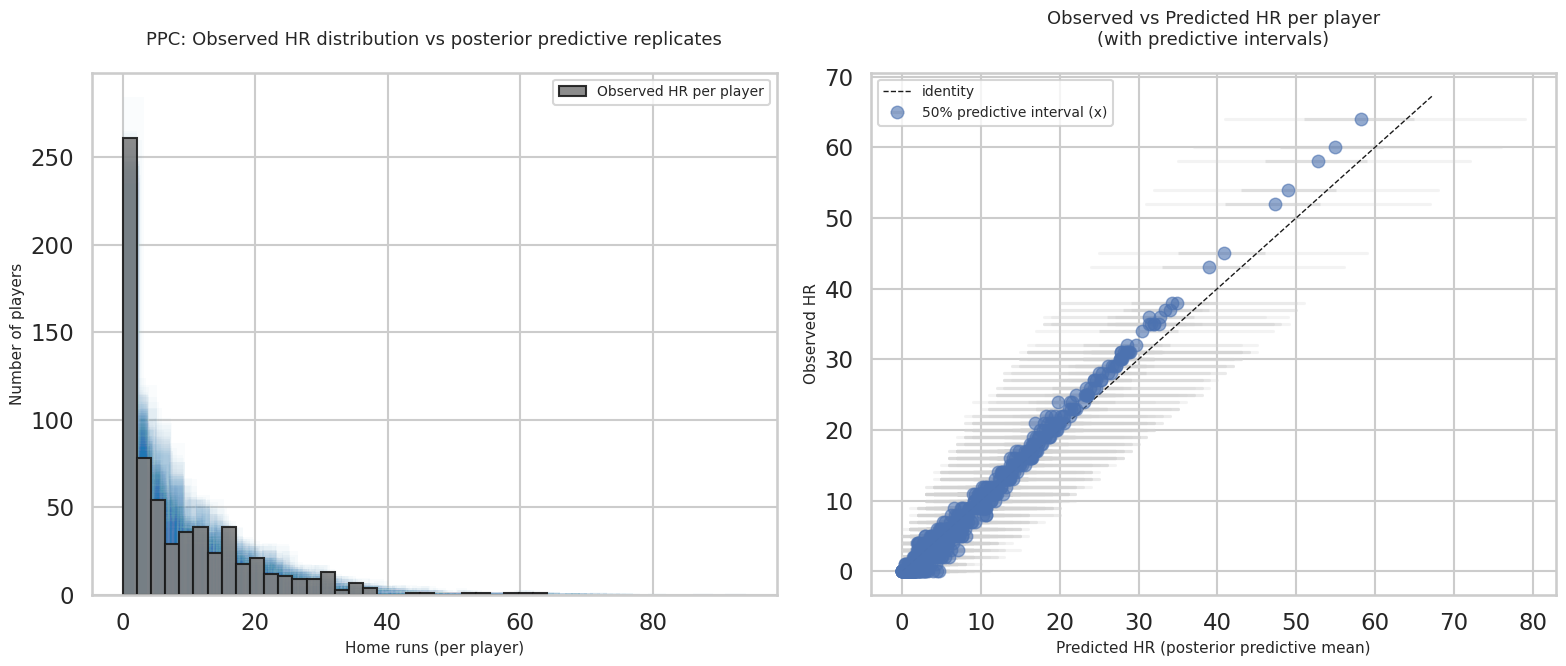

In [25]:
# Step 1: Posterior Predictive Checks (PPC)

with hierarchical_model:
    ppc = pm.sample_posterior_predictive(idata, var_names=["hr_obs"], random_seed=SEED)

# ppc.posterior_predictive["hr_obs"] shape: (chain, draw, N)
ppc_hr = ppc.posterior_predictive["hr_obs"].values
chains, draws, nplayers = ppc_hr.shape
ppc_flat = ppc_hr.reshape(-1, nplayers)  # shape (chains*draws, N)

# Select a subset of predictive replicates to overlay for Panel A
replicates_to_plot = 200
sel_idx = np.random.RandomState(SEED).choice(
    ppc_flat.shape[0],
    size=min(replicates_to_plot, ppc_flat.shape[0]),
    replace=False
)

# Create figure and axes
fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # slightly larger for better spacing
ax1, ax2 = axes

# Panel A: Many predictive replicate histograms + observed histogram
for idx in sel_idx:
    ax1.hist(ppc_flat[idx], bins=30, alpha=0.02, color='tab:blue')
ax1.hist(HR, bins=30, alpha=0.9, label="Observed HR per player",
         color='grey', edgecolor='k')
ax1.set_xlabel("Home runs (per player)", fontsize=11)
ax1.set_ylabel("Number of players", fontsize=11)
ax1.set_title("PPC: Observed HR distribution vs posterior predictive replicates",
              fontsize=13, pad=20)  # add pad to move title upward
ax1.legend(fontsize=10)

# Panel B: Observed vs Predicted HR with predictive intervals
ppc_means_per_player = ppc_flat.mean(axis=0)
ppc_q025 = np.percentile(ppc_flat, 2.5, axis=0)
ppc_q975 = np.percentile(ppc_flat, 97.5, axis=0)
ppc_q25 = np.percentile(ppc_flat, 25, axis=0)
ppc_q75 = np.percentile(ppc_flat, 75, axis=0)

ax2.errorbar(ppc_means_per_player, HR,
             xerr=[np.maximum(0, ppc_means_per_player - ppc_q25),
                   np.maximum(0, ppc_q75 - ppc_means_per_player)],
             fmt='o', alpha=0.6, label='50% predictive interval (x)',
             ecolor='lightgray', capsize=0)
for i in range(nplayers):
    ax2.plot([ppc_q025[i], ppc_q975[i]], [HR[i], HR[i]], color='lightgray', alpha=0.25)  # 95% interval

maxval = max(HR.max(), ppc_means_per_player.max()) * 1.05
ax2.plot([0, maxval], [0, maxval], 'k--', lw=1, label='identity')
ax2.set_xlabel("Predicted HR (posterior predictive mean)", fontsize=11)
ax2.set_ylabel("Observed HR", fontsize=11)
ax2.set_title("Observed vs Predicted HR per player\n(with predictive intervals)",
              fontsize=13, pad=20)
ax2.legend(fontsize=10)

# Adjust spacing to prevent overlap
plt.subplots_adjust(wspace=0.35, top=0.88)  # horizontal and vertical spacing
plt.tight_layout()
plt.show()


In [26]:
# Step 2: Posterior predictive p-values (mean and variance across players)

obs_mean = HR.mean()
obs_var = HR.var(ddof=0)

rep_means = ppc_flat.mean(axis=1)   # mean across players for each replicate
rep_vars = ppc_flat.var(axis=1)

pval_mean = np.mean(rep_means >= obs_mean)
pval_var = np.mean(rep_vars >= obs_var)

print(f"Observed mean HR per player = {obs_mean:.3f}, predictive p-value = {pval_mean:.3f}")
print(f"Observed var HR across players = {obs_var:.3f}, predictive p-value = {pval_var:.3f}")


Observed mean HR per player = 8.518, predictive p-value = 0.502
Observed var HR across players = 103.917, predictive p-value = 0.097


**Goal 4: Reflection on shrinkage of player rates in the dataset.**

My hierarchical model demonstrates shrinkage of player home run rates toward the league mean. Even in the top 20, HR/AB varies from Cal Raleigh at 0.100 to Matt Wallner at 0.065. The hierarchical Bayesian model shrinks extreme HR/AB down toward the mean and slightly increases estimates for smaller sample sizes. For example, Giancarlo Stanton's HR/AB is 0.087, however his posterior is 0.072 due to fewer at-bats. This reflects the model's logic where the prior is weighted using both observed performance and overall uncertainty, so players with fewer at-bats or extreme performances experience stronger adjustments. This reduces the influence of chance in small samples. On the flipside, players with large sample sizes such as Cal Raleigh and Shohei Ohtani see less shrinkage. Overall, the model provides reliable home run rate estimates, reduces overfitting in small samples, and preserves meaningful differences among the top performers.

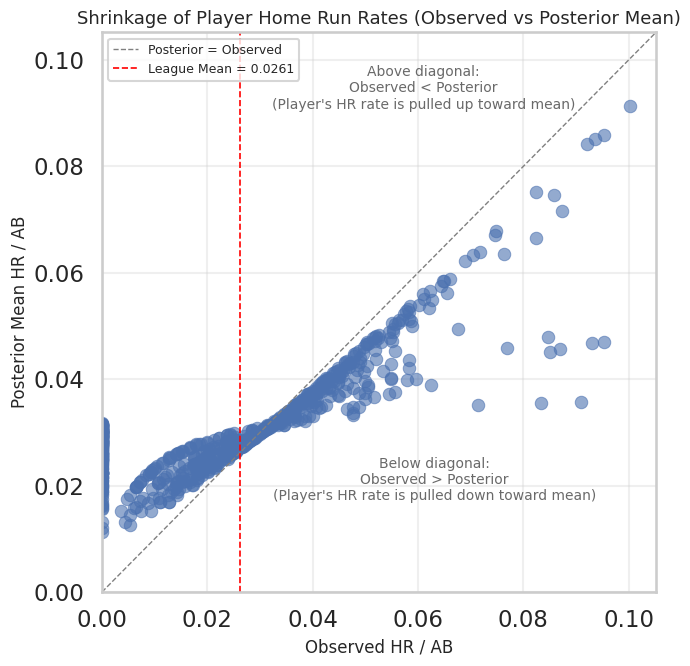

In [27]:
# Illustration 1: Shrinkage Illustration

# Compute observed HR/AB if not already in df

if "HR/AB" not in df.columns:
    df["HR/AB"] = df["HR"] / df["AB"]

# Calculate league mean observed HR/AB

league_mean = df["HR/AB"].mean()

# Create scatter plot

plt.figure(figsize=(7, 7))
sns.scatterplot(
    x=df["HR/AB"],
    y=df["hier_post_mean"],
    alpha=0.6,
    edgecolor=None
)

# 45° reference line (posterior = observed)

lims = [
    0,
    max(df["HR/AB"].max(), df["hier_post_mean"].max()) * 1.05
]
plt.plot(lims, lims, "--", color="gray", linewidth=1, label="Posterior = Observed")

# Vertical line for league mean

plt.axvline(league_mean, color="red", linestyle="--", linewidth=1.2, label=f"League Mean = {league_mean:.4f}")

# Add compact position-based labels

plt.text(lims[1]*0.58, lims[1]*0.9,
         "Above diagonal:\nObserved < Posterior\n(Player's HR rate is pulled up toward mean)",
         ha="center", va="center", fontsize=10, color="dimgray")

plt.text(lims[1]*0.6, lims[1]*0.2,
         "Below diagonal:\nObserved > Posterior\n(Player's HR rate is pulled down toward mean)",
         ha="center", va="center", fontsize=10, color="dimgray")

# Formatting

plt.title("Shrinkage of Player Home Run Rates (Observed vs Posterior Mean)", fontsize=13)
plt.xlabel("Observed HR / AB", fontsize=12)
plt.ylabel("Posterior Mean HR / AB", fontsize=12)
plt.xlim(lims)
plt.ylim(lims)
plt.grid(alpha=0.3)

# Compact legend inside the plot

plt.legend(loc='upper left', fontsize=9, markerscale=0.7, framealpha=0.8)

plt.tight_layout()
plt.show()